# Import data and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, accuracy_score

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import scripts

# constants and settings
rand_seed = 35

2025-11-26 13:50:46.813884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load the data
tree_data = pd.read_csv('../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())

In [6]:
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(f"Dataset shape: {tree_data.shape}")

Nan values in dataset: 0
Dataset shape: (581012, 55)


# Data exploration

In [7]:
# tree_reduced = scripts.sample_stratify(tree_data, 'Cover_Type', n_samples=100000, rand_state=rand_seed)
tree_reduced = tree_data.copy()
X_tree, y_tree = tree_reduced.drop(columns=['Cover_Type']), tree_reduced['Cover_Type']
y_tree -= 1  # make labels zero-indexed

Very uneven label distribution, mostly centered on types 1 and 2.
Stratified sampling require to ensure labels 3-7 are properly represented in training.

In [ ]:
# std_scaler, x_st_scale = scripts.normalize_data(X_tree, method='standard')
scaler = preproc.StandardScaler()
x_st_scale = scaler.fit_transform(X_tree)

## Split training/testing data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_st_scale, y_tree, test_size=0.2, stratify=y_tree, random_state=rand_seed)
print("Training counts before resampling:")
print(y_train.value_counts())

In [ ]:
# target_over = {3: 1000, 4: 1000, 5: 1000, 6: 1000}
target_over = {3: 6000}
# target_under = {0: 1000, 1: 1000, 2: 1000}
target_under = {0: 35000, 1: 35000}

In [ ]:
# Oversample minority categories
x_resample, y_resample = SMOTE(random_state=rand_seed, sampling_strategy=target_over, k_neighbors=2).fit_resample(x_train, y_train)
scripts.plot_histogram(y_resample, label='Cover Type after Oversampling')

# Undersample majority categories
x_resample, y_resample = RandomUnderSampler(random_state=rand_seed, sampling_strategy=target_under).fit_resample(x_resample, y_resample)
scripts.plot_histogram(y_resample, label='Cover Type after Undersampling')

# resample data
x_resample, y_resample = scripts.resample_data(x_train, y_train,
                                              target_over=target_over,
                                              target_under=target_under)

x_train, x_val, y_train, y_val = train_test_split(x_resample, y_resample, test_size=0.2, stratify=y_resample, random_state=rand_seed)

In [14]:
# load preprocessed data
import scripts
training_data, validation_data, test_data = scripts.load_processed_data('../data', prefix='two_under')
x_train, y_train = training_data[tree_cols[:-1]], training_data['Cover_Type']
x_val, y_val = validation_data[tree_cols[:-1]], validation_data['Cover_Type']
x_test, y_test = test_data[tree_cols[:-1]], test_data['Cover_Type']

# Perceptron model training

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

mlp = scripts.MLPModel(input_dim=x_train.shape[1], 
                         num_classes=7,
                         learning_rate=1e-4)

mlp.set_train(x_train, y_train)
mlp.set_val(x_val, y_val)
mlp.set_test(x_test, y_test)

In [16]:
mlp.build_model()
mlp.overview()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │        28,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,407 (1.12 MB)

 Trainable params: 294,407 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = mlp.train(epochs=400, callbacks=[es], verbose=1)

Epoch 1/400
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5978 - loss: 1.1322 - val_accuracy: 0.6665 - val_loss: 0.8482
Epoch 2/400
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6831 - loss: 0.7902 - val_accuracy: 0.6941 - val_loss: 0.7519
Epoch 3/400
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7022 - loss: 0.7249 - val_accuracy: 0.7093 - val_loss: 0.7051
Epoch 4/400
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7130 - loss: 0.6862 - val_accuracy: 0.7170 - val_loss: 0.6727
Epoch 5/400
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7216 - loss: 0.6575 - val_accuracy: 0.7296 - val_loss: 0.6479
Epoch 6/400
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7304 - loss: 0.6346 - val_accuracy: 0.7339 - val_loss: 0.6265
Epoch 7/400
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7383 - loss: 0.6166 - val_accuracy: 0.7418 - val_loss: 0.6084
Epoch 8/400
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7440 - loss: 0.6017 - val_acc

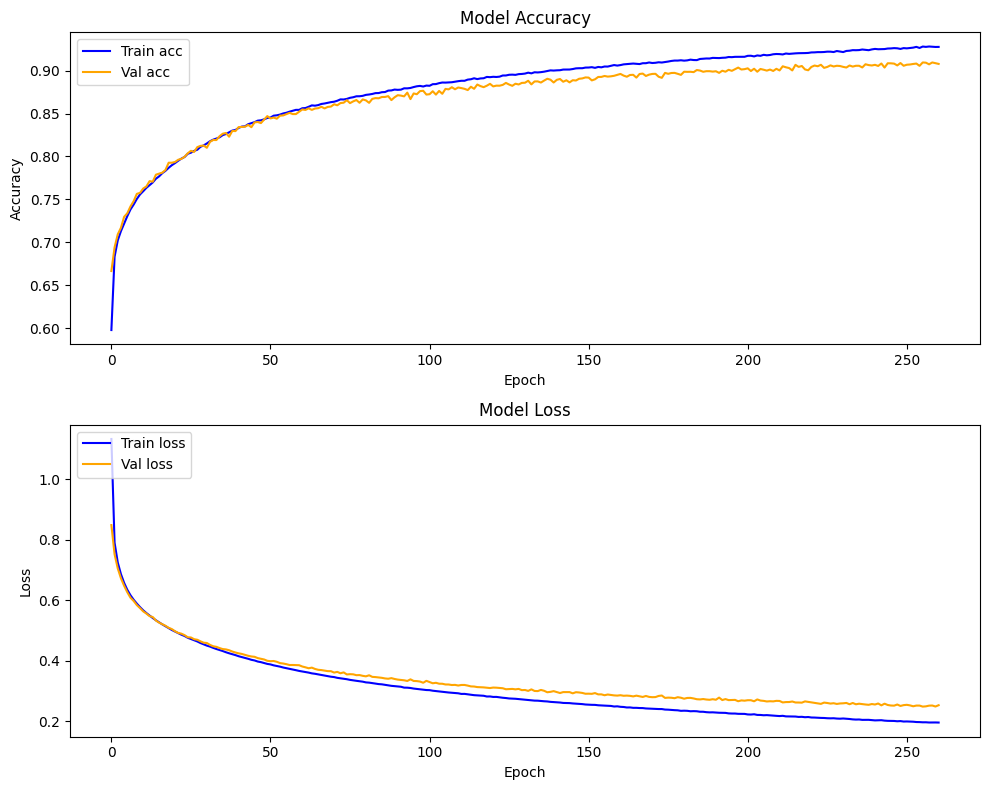

In [18]:
mlp.visualize_history(history)

Accuracy: 0.8816
Matthews Correlation Coefficient: 0.8133
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88     21184
           1       0.91      0.88      0.89     28331
           2       0.84      0.95      0.89      3575
           3       0.90      0.78      0.84       275
           4       0.63      0.88      0.73       949
           5       0.77      0.87      0.82      1737
           6       0.83      0.98      0.90      2051

    accuracy                           0.88     58102
   macro avg       0.82      0.89      0.85     58102
weighted avg       0.88      0.88      0.88     58102



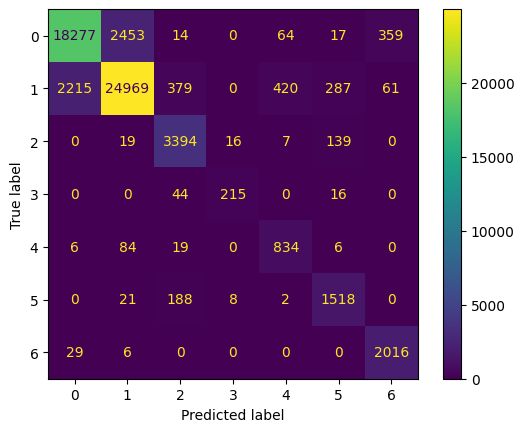

In [19]:
cmd, mcm, class_report, mcc = mlp.evaluate()
cmd.plot()
print(f"Accuracy: {accuracy_score(y_test, mlp.predict(x_test)):.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print("Classification Report:\n", class_report)